----
# 📦 Resampling Methods #
----




## **Concepts Covered:**

- <a href = #link1>1. 📝 Preliminaries</a>  
- <a href = #link2>2. ⚙️ Data Preparation for Model Building</a>  
- <a href = #link3>3. 🔍 Recursive Feature Elimination (RFE)</a>  
- <a href = #link3-1>3.1 RFE Implementation</a>  
- <a href = #link4>4. 🔁 Cross Validation</a>  
- <a href = #link4-1>4.1 Elbow Criterion</a>  


---
<a id="link1"></a>
## 1. 📝 Preliminaries


### 🎯 What you'll learn (Resampling Methods)
- Why we resample data we **already have**
- How **train/test split** and **cross‑validation** estimate generalization error
- How to use the **bootstrap** to quantify uncertainty (SEs, CIs, bias)
- Practical guidance: choosing $k$, avoiding leakage, and reporting results

> **TL;DR** Resampling trades a bit of computation for a big gain in **honest evaluation** and **model robustness**.


In [46]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

Loading the Data Set

In [71]:
# import Housing.csv
housing = pd.read_csv('/Users/fernandodiaz/Library/CloudStorage/OneDrive-UniversidadTécnicaFedericoSantaMaría/Machine Learning Supervisado/Data/Housing.csv')
housing.head()


 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [72]:
# number of observations 
len(housing)

545

In [73]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


----
## ⚙️ (2) Data Preparation for Model Building

Before we proceed to build any model, we need to **prepare our data** carefully:

- 🔡 **Encode categorical features** → convert text variables (`yes`/`no`, `furnished`/`unfurnished`, etc.) into numeric format.  
- ➗ **Separate variables** → define **independent variables (X)** and the **dependent variable (y)**.  
- 🔀 **Train/Test split** → divide the dataset into **training** and **testing** parts to evaluate model performance on unseen data.  

👉 Proper preparation ensures **fair evaluation**, avoids **data leakage**, and makes the pipeline reproducible.



In [74]:

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


The `binary_map` function is designed to convert binary categorical variables into numerical format, specifically mapping 'yes' to 1 and 'no' to 0. This function takes a pandas series **x** as input and applies the `.map()` method to transform its values based on the provided dictionary.

What are the levels of the variable **furnishingstatus**?

In [75]:
housing['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [76]:
housing = pd.get_dummies(
    housing,
    columns=['furnishingstatus'],  # Specify the column(s) we want to encode as a list
    drop_first=True)  # This option drops the first category to avoid the dummy variable trap



In [77]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


## 🏡 Data Dictionary — Housing Dataset

The dataset contains **545 observations** and **13 variables** about houses and their characteristics:

- **price** 💰 — Sale price of the house (in currency units).  
- **area** 📐 — Total area of the house (in square feet).  
- **bedrooms** 🛏️ — Number of bedrooms.  
- **bathrooms** 🚿 — Number of bathrooms.  
- **stories** 🏢 — Number of floors/stories in the house.  
- **mainroad** 🛣️ — Whether the house is located on the main road (`yes`/`no`).  
- **guestroom** 🚪 — Whether the house has a guest room (`yes`/`no`).  
- **basement** 🏚️ — Whether the house has a basement (`yes`/`no`).  
- **hotwaterheating** 🔥 — Availability of hot water heating (`yes`/`no`).  
- **airconditioning** ❄️ — Availability of air conditioning (`yes`/`no`).  
- **parking** 🚗 — Number of parking spaces available.  
- **prefarea** 🌳 — Whether the house is located in a preferred area (`yes`/`no`).  
- **furnishingstatus** 🛋️ — Status of furnishing (`furnished`, `semi-furnished`, `unfurnished`).  

---

👉 This dataset will be used for **resampling methods** (cross-validation, bootstrap, etc.) to predict house prices and evaluate model performance.


For ease of use, we rename **furnishingstatus** variables.

In [78]:
housing.rename(columns={
    'furnishingstatus_semi-furnished': 'semi-furnished',
    'furnishingstatus_unfurnished': 'unfurnished'
}, inplace=True)


**Note**:

* The parameter `inplace=True` is frequently used in various functions and methods across Python libraries, especially in Pandas, to specify whether to modify the original DataFrame (or Series) directly, rather than returning a new object with the modifications applied. When `inplace=True` is used, the operation will alter the original DataFrame and return None, implying that the original object has been changed in place and no new object is created. Conversely, if `inplace=False` (which is often the default setting), the operation will return a new DataFrame with the modifications, leaving the original DataFrame unchanged.

* Always ensure that you do not need the original DataFrame unchanged before using `inplace=True`.

In [79]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [80]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   price            545 non-null    int64
 1   area             545 non-null    int64
 2   bedrooms         545 non-null    int64
 3   bathrooms        545 non-null    int64
 4   stories          545 non-null    int64
 5   mainroad         545 non-null    int64
 6   guestroom        545 non-null    int64
 7   basement         545 non-null    int64
 8   hotwaterheating  545 non-null    int64
 9   airconditioning  545 non-null    int64
 10  parking          545 non-null    int64
 11  prefarea         545 non-null    int64
 12  semi-furnished   545 non-null    bool 
 13  unfurnished      545 non-null    bool 
dtypes: bool(2), int64(12)
memory usage: 52.3 KB


The dummy variables `semi-furnished` and `unfurnished` are **boolean**. Let's transform them to numeric values:

In [81]:

housing['semi-furnished'] = housing['semi-furnished'].astype(int)
housing['unfurnished'] = housing['unfurnished'].astype(int)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


We will use the **train_test_split** function  to split the dataset into random train and test subsets (https://scikit-learn.org/stable/).

In [82]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)


The illsutrate the **Cross Validation** algorythm, we will perform **Recursive Feature Elimination (RFE)**. This is is a feature selection technique that fits a model and removes the weakest feature (or features) until the specified number of features is reached. 

When using RFE with a model that is sensitive to the scale of the input features, scaling is necessary because it ensures that all features are treated equally in terms of their importance. 

In any case, it should be noted that for linear regression feature scaling is not strictly necessary for the model to perform well in terms of finding the optimal coefficients that minimize the cost function. Linear regression is scale-invariant for the purpose of fitting the model. 

The `MinMaxScaler` is a preprocessing tool from scikit-learn. It scales and transforms each feature individually such that it is in a given range, e.g., between zero and one. This type of scaling is beneficial for optimization algorithms used in the core of machine learning algorithms like gradient descent, as it can lead to faster convergence. Additionally, it is useful when the algorithm makes assumptions about the uniformity of the features, such as k-nearest neighbors and k-means clustering.

After fitting the scaler to the data, it calculates the minimum (`min_`) and range (`scale_`) of the data. These values are then used to scale the data according to the formula:

$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

where $X_{\text{min}}$ and $X_{\text{max}}$ are the minimum and maximum values of the input feature, respectively. The scaled data $X_{\text{scaled}}$ is then within the specified `feature_range`.

In [83]:
scaler = MinMaxScaler()

# Apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [84]:
# Apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


Finally, we divide the data into X_train, y_train, X_test, y_test

In [85]:
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

y_train.head()

359    0.169697
19     0.615152
159    0.321212
35     0.548133
28     0.575758
Name: price, dtype: float64

**Observation**:

The `pop` method is a way to both retrieve a column from a DataFrame and remove it from the original DataFrame at the same time.

---
## 🔍 (3) Recursive Feature Elimination (RFE)

**Recursive Feature Elimination (RFE)** is a feature selection method that helps identify which features contribute the most to predicting the target variable by **recursively removing the least important features**.  

The process works as follows:  

1. 🤖 **Model Fitting**  
   - Train a predictive model that assigns weights to features (e.g., regression coefficients, decision tree importances).  
   - Start with the **entire set of features**.  

2. 📊 **Ranking of Features**  
   - Rank features based on a criterion (often the **absolute value of coefficients** or feature importances).  
   - The feature(s) with the **smallest impact** are ranked lowest.  

3. ✂️ **Elimination of the Least Important Feature(s)**  
   - Remove the weakest feature(s).  
   - By default, one feature is removed at a time (though you can remove more).  

4. 🔁 **Repetition of the Process**  
   - Re-fit the model with the reduced feature set.  
   - Re-rank features and eliminate again.  
   - Repeat until only the desired number of features remain.  

5. 🏆 **Selection of the Best Subset**  
   - The remaining features form the **most informative subset**, improving interpretability, reducing dimensionality, and often enhancing performance.  

---

✨ **Why use RFE?**  
- Improves **interpretability** by focusing on the most relevant features.  
- Helps reduce **multicollinearity**.  
- Can enhance **model performance** by removing noisy or redundant predictors.  



We have 13 features in our data set:

In [86]:
# num of max features
len(X_train.columns)



13

We will first run the model including all features:

In [87]:

lm = LinearRegression()  # Intialize the model
lm.fit(X_train, y_train)


LinearRegression()

To display a table with regression results after fitting a linear model using **scikit-learn**, we'll need to manually compile the results since scikit-learn itself primarily focuses on prediction and does not provide detailed regression summaries out of the box like some other libraries (**statsmodels**). 

In [88]:
from sklearn.metrics import mean_squared_error


# Extract coefficients and intercept
coefficients = lm.coef_
intercept = lm.intercept_

# Calculate R^2 and RMSE
r_squared = lm.score(X_train, y_train)
predictions = lm.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions))

# Creating summary table
summary_data = {
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient': np.append(intercept, coefficients)
}
summary_df = pd.DataFrame(summary_data)

# Displaying performance metrics
print(f"R^2: {r_squared:.3f}")
print(f"RMSE: {rmse:.3f}")

# Displaying coefficients table
print(summary_df)


R^2: 0.681
RMSE: 0.089
            Feature  Coefficient
0         Intercept     0.020033
1              area     0.234664
2          bedrooms     0.046735
3         bathrooms     0.190823
4           stories     0.108516
5          mainroad     0.050441
6         guestroom     0.030428
7          basement     0.021595
8   hotwaterheating     0.084863
9   airconditioning     0.066881
10          parking     0.060735
11         prefarea     0.059428
12   semi-furnished     0.000921
13      unfurnished    -0.031006


<a id="link3-1"></a>
### ⚙️ 3.1 RFE Implementation

Now that we know the intuition behind **Recursive Feature Elimination (RFE)**, let’s see how to implement it in practice.  

👉 The idea:  
- Start with **all features** (we just did it).  
- Use a model (e.g., Linear Regression, Decision Tree) to **rank feature importance**.  
- Iteratively **remove the least important feature(s)** until the optimal subset is found.  

In `scikit-learn`, this is done with the class **`RFE`** (or `RFECV` if you want RFE + Cross Validation in one step).  

Steps we’ll follow:  
1. 📥 Choose a base model (e.g., `LinearRegression`).  
2. 🧮 Apply **RFE** to select the top $k$ features.  
3. 📊 Evaluate the performance of the reduced feature set.  

This allows us to balance **simplicity** (fewer predictors) and **accuracy** (low error).  


Now, we will perform RFE to the model with an arbitrary choice of features (10).

In [89]:
n_features = 10
rfe = RFE(lm, n_features_to_select=n_features)             
rfe = rfe.fit(X_train, y_train)

Let's retrieve the coefficients of the selected features:

In [90]:
# Extracting the coefficients of the selected features
selected_features = X_train.columns[rfe.support_]
selected_coefficients = rfe.estimator_.coef_

# Creating a DataFrame for easier visualization
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': selected_coefficients
})

# Displaying the selected features and their coefficients
print(coefficients_df)

           Feature  Coefficient
0             area     0.236257
1         bedrooms     0.066102
2        bathrooms     0.198169
3          stories     0.097722
4         mainroad     0.055649
5        guestroom     0.038136
6  hotwaterheating     0.089673
7  airconditioning     0.071079
8          parking     0.063739
9         prefarea     0.064326


Now, predicted prices on the test data set are obtained and the model is evaluates using $R^2$:

In [91]:
# Predict prices of X_test
y_pred = rfe.predict(X_test)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R^2:",r2)

# Calculating Adjusted R^2
n = len(X_test)
p = n_features
adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)

print("Adjusted R^2:", adjusted_r2)


R^2: 0.5812051458999572
Adjusted R^2: 0.5538329332136799


In [92]:
# try with another value of RFE

n_features = 6
rfe = RFE(lm, n_features_to_select=n_features)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R^2:",r2)

# Calculating Adjusted R^2
n = len(X_test)
p = n_features
adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)

print("Adjusted R^2:", adjusted_r2)



R^2: 0.5350445027578822
Adjusted R^2: 0.517275502863279


Note that the number of features used in the model is a hyperparameter that should be tuned. Cross-validation is a widely used technique in machine learning to assess the generalizability of models.  When combined with hyperparameter tuning, it allows for a more systematic and robust selection of model settings.

---
## 🔁 (4) Cross Validation

**Cross Validation (CV)** is a resampling technique used to **evaluate how well a model generalizes** to unseen data.  
Instead of relying on a single train/test split, CV repeatedly splits the dataset into *training* and *validation* parts, providing a more robust estimate of performance.  

---

### ✨ Why use Cross Validation?
- 📉 Reduces the risk of **overfitting** to a particular train/test split.  
- 📊 Provides a more **reliable estimate** of the true prediction error.  
- 🔍 Useful for **model selection** (choosing the best algorithm or hyperparameters).  

---

### 🔑 Main Approaches
1. **LOOCV (Leave-One-Out CV)**  
   - Train on $n-1$ observations, test on the single left-out observation.  
   - Repeat $n$ times.  
   - ✅ Low bias, ❌ high variance and computationally expensive.  

2. **k-Fold CV**  
   - Split the dataset into $k$ equal folds.  
   - Train on $k-1$ folds, validate on the remaining fold.  
   - Repeat $k$ times and average the errors.  
   - ✅ Balanced bias-variance tradeoff; common choices $k = 5$ or $10$.  

3. **Stratified k-Fold CV** (for classification)  
   - Ensures each fold preserves the **class distribution** of the dataset.  

---



### ⚠️ Important Note on Cross Validation and Train/Test Split

Cross Validation is often confused with the final **train/test split**. Here’s the distinction:

- 🔁 **Cross Validation (CV)** is applied to the **entire dataset** to estimate how the model would perform on unseen data.  
- 🧪 **Train/Test split** is usually reserved until the very end, providing a **final unbiased evaluation** after model selection and tuning.  

👉 A typical workflow:  
1. 📂 Start with the **full dataset**.  
2. 🔁 Use **cross validation** (on the full dataset) to compare models and tune hyperparameters.  
3. ✂️ After choosing the best model, perform a **train/test split** (or keep a held-out test set from the beginning) for a final performance check.  

This ensures that:  
- CV is used for **model selection**.  
- The test set is used **once** for **final validation**, avoiding data leakage.  


In [93]:
df_y = pd.concat([y_train, y_test], ignore_index=True)
print(df_y.head())
df_y.shape

0    0.169697
1    0.615152
2    0.321212
3    0.548133
4    0.575758
Name: price, dtype: float64


(545,)

In [94]:

df_X = pd.concat([X_train, X_test], ignore_index=True)
print(df_X.head())
df_X.shape

       area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
0  0.155227       0.4        0.0  0.000000         1          0         0   
1  0.403379       0.4        0.5  0.333333         1          0         0   
2  0.115628       0.4        0.5  0.000000         1          1         1   
3  0.454417       0.4        0.5  1.000000         1          0         0   
4  0.538015       0.8        0.5  0.333333         1          0         1   

   hotwaterheating  airconditioning   parking  prefarea  semi-furnished  \
0                0                0  0.333333         0               0   
1                0                1  0.333333         1               1   
2                0                1  0.000000         0               0   
3                0                1  0.666667         0               0   
4                1                0  0.666667         0               0   

   unfurnished  
0            1  
1            0  
2            0  
3            0  
4

(545, 13)

In [95]:
# Append df_X to df_y along the columns (axis=1)
df = pd.concat([df_y, df_X], axis=1).reset_index(drop=True)
print(df.head())
df.shape

      price      area  bedrooms  bathrooms   stories  mainroad  guestroom  \
0  0.169697  0.155227       0.4        0.0  0.000000         1          0   
1  0.615152  0.403379       0.4        0.5  0.333333         1          0   
2  0.321212  0.115628       0.4        0.5  0.000000         1          1   
3  0.548133  0.454417       0.4        0.5  1.000000         1          0   
4  0.575758  0.538015       0.8        0.5  0.333333         1          0   

   basement  hotwaterheating  airconditioning   parking  prefarea  \
0         0                0                0  0.333333         0   
1         0                0                1  0.333333         1   
2         1                0                1  0.000000         0   
3         0                0                1  0.666667         0   
4         1                1                0  0.666667         0   

   semi-furnished  unfurnished  
0               0            1  
1               1            0  
2               0      

(545, 14)

In [96]:
y_df = df.pop('price')
X_df = df


In [97]:

# number of features in X_train
len(X_df.columns)



13

### ⚙️ Cross Validation with GridSearchCV + RFE

Now that we understand **Cross Validation** and **Recursive Feature Elimination (RFE)**, let’s combine them using **`GridSearchCV`**.  

👉 The idea is to:  
1. 📑 **Define a CV scheme** → how the dataset will be split into folds (e.g., 5-fold CV).  
2. ⚖️ **Specify a hyperparameter grid** → here, the number of features to select in RFE.  
3. 🔍 **Run a grid search** → for each hyperparameter setting, train + validate using CV, and compute the performance metric (here, negative MSE).  
4. 🏆 **Pick the best model** → the setting with the lowest CV error (highest negative MSE).  

This ensures that the **choice of features** is data-driven and validated across multiple folds, instead of relying on a single split.  


In [99]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_df, y_df)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_df, y_df)      

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

![Cross Validation](../images/Figures/cross_validation.PNG)


Source: "Understanding Cross-Validation in Machine Learning
"

(https://www.pythonshot.com/2024/09/understanding-cross-validation-in.html)

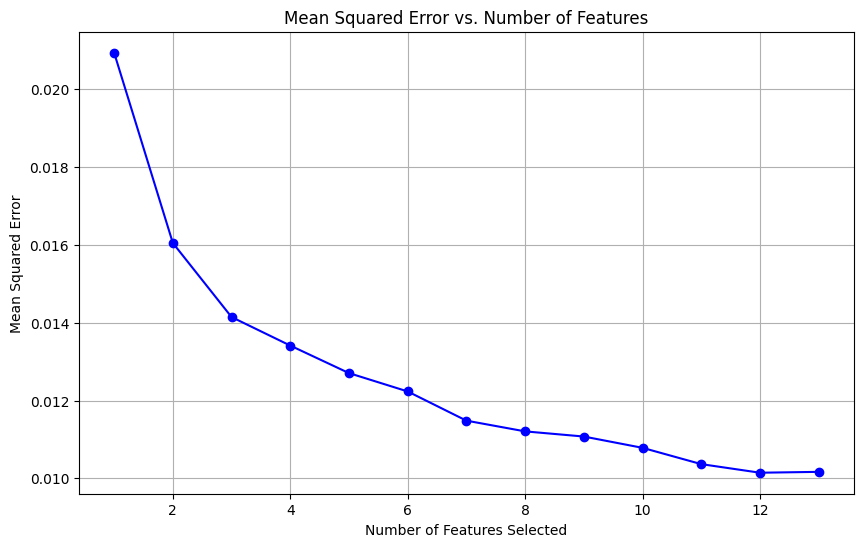

In [101]:
# Extract the mean test scores (negative MSE) and convert to positive MSE
mean_test_scores = -model_cv.cv_results_['mean_test_score']

# The number of features tested in each hyperparameter setting
n_features_to_select = [param['n_features_to_select'] for param in model_cv.cv_results_['params']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_features_to_select, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('Mean Squared Error vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


### 📊 Interpreting the CV Results Plot

The curve shows the **Mean Squared Error (MSE)** for different values of  
`n_features_to_select` (the number of features kept by RFE).  

👉 Important points to notice:  
- Each MSE value is the **average across the 5 CV folds**, so it reflects how the model performs on unseen data in a more stable way.  
- The **minimum point** on the curve corresponds to the **optimal number of features**, i.e., the subset that gives the lowest prediction error.  
- If the curve is relatively flat after a certain number of features, we can apply the **elbow rule** or the **one-standard-error rule** to choose a simpler model with almost the same performance.  

📌 **Takeaway**:  
Cross-validation ensures that our feature selection is not biased by a single train/test split. Instead, it provides a reliable estimate of how many features truly improve generalization.  


<a id="link4-1"></a>
### 📐 4.1 Elbow Criterion

The **Elbow Criterion** is a heuristic used to decide the *optimal level of model complexity* by looking for a point of **diminishing returns**.  

---

#### 🧠 Where it’s commonly applied:
- **K-Means Clustering** → Plot the *within-cluster sum of squares* vs. the number of clusters.  
- **PCA (Principal Component Analysis)** → Plot the *explained variance* vs. the number of principal components.  

In both cases, the curve initially decreases sharply (big gains in performance), but after a certain point, improvements become marginal. This creates an **“elbow” shape** in the plot, and the elbow point is chosen as the optimal balance between **simplicity** and **accuracy**.  

---

#### 🔎 Applying the idea to Feature Selection (RFE + CV)
While the Elbow Criterion isn’t a formal method for RFE, the same intuition applies:  
- Plot **CV error (e.g., MSE)** vs. **number of features selected**.  
- Look for the point where adding more features yields little to no improvement.  
- Choose the **elbow point** as the optimal subset of features.  

---

✨ **Key takeaway:**  
The Elbow Criterion helps us avoid overly complex models by picking the **simplest model that performs nearly as well as the most complex one**.  


![elbow.png](../images/Figures/Elbow.png)

Source: "Fast Single- and Cross-Show Speaker Diarization Using Binary Key Speaker Modeling"

(https://ieeexplore.ieee.org/document/7268861)

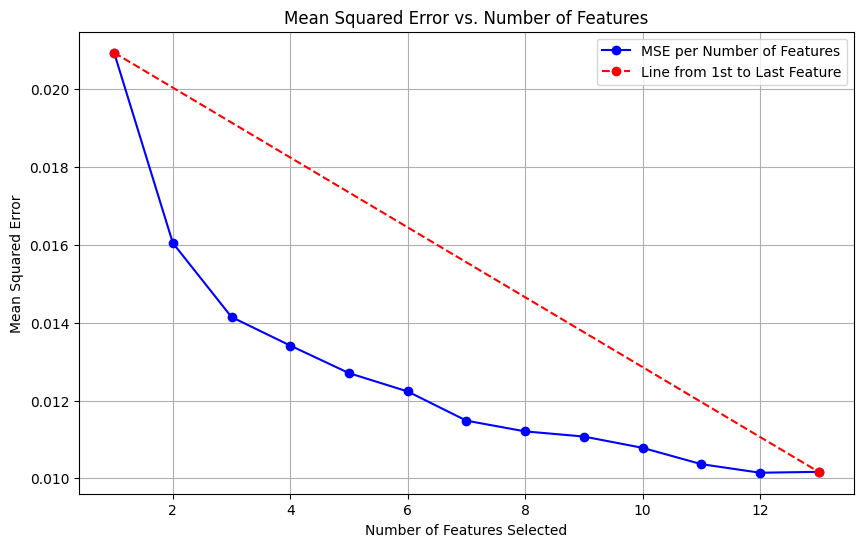

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_test_scores and n_features_to_select are already defined as before

# Plotting the original MSE values
plt.figure(figsize=(10, 6))
plt.plot(n_features_to_select, mean_test_scores, marker='o', linestyle='-', color='b', label='MSE per Number of Features')

# Adding a line between the first and last point in red
plt.plot([n_features_to_select[0], n_features_to_select[-1]], [mean_test_scores[0], mean_test_scores[-1]], color='red', linestyle='--', marker='o', label='Line from 1st to Last Feature')

plt.title('Mean Squared Error vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()


To compute the distance between each point, representing the Mean Squared Error (MSE) for a specific number of features, and the red line, which connects the first and last points in our plot, we use the formula for the perpendicular distance from a point to a line in a 2D plane. The formula for the distance \(d\) from a point \((x_0, y_0)\) to a line given by \(Ax + By + C = 0\) is:

$$ d = \frac{|Ax_0 + By_0 + C|}{\sqrt{A^2 + B^2}} $$

For the line segment between the first point \((x_1, y_1)\) and the last point \((x_2, y_2)\), we derive \(A\), \(B\), and \(C\) by converting the line segment equation into the general line equation format:

$$ A = y_2 - y_1 $$
$$ B = x_1 - x_2 $$
$$ C = x_2y_1 - x_1y_2 $$

Given these, we can calculate the distances for each point (representing different numbers of features and their corresponding MSE values) to this line. 

In [103]:

x1, y1 = n_features_to_select[0], mean_test_scores[0]
x2, y2 = n_features_to_select[-1], mean_test_scores[-1]

# Coefficients for the line equation
A = y2 - y1
B = x1 - x2
C = x2*y1 - x1*y2

# Calculate distances from each point to the line
distances = np.abs(A * np.array(n_features_to_select) + B * np.array(mean_test_scores) + C) / np.sqrt(A**2 + B**2)

# Create a DataFrame to display the number of features and their corresponding distances
df = pd.DataFrame({
    'Number of Features': n_features_to_select,
    'Distance to Line': distances
})

print(df)


    Number of Features  Distance to Line
0                    1      0.000000e+00
1                    2      3.992673e-03
2                    3      4.998396e-03
3                    4      4.833768e-03
4                    5      4.643517e-03
5                    6      4.217539e-03
6                    7      4.070197e-03
7                    8      3.448283e-03
8                    9      2.682899e-03
9                   10      2.075799e-03
10                  11      1.596793e-03
11                  12      9.200334e-04
12                  13      4.625927e-18


In [104]:
# Calculate distances from each point to the line (as done previously)
# distances = np.abs(A * np.array(n_features_to_select) + B * np.array(mean_test_scores) + C) / np.sqrt(A**2 + B**2)

# Find the index of the maximum distance
max_distance_index = np.argmax(distances)

# Use this index to find the corresponding number of features
max_distance_features = n_features_to_select[max_distance_index]
max_distance_value = distances[max_distance_index]

print(f"The point with the maximum distance to the red line corresponds to {max_distance_features} features, with a distance of {max_distance_value:.4f}.")


The point with the maximum distance to the red line corresponds to 3 features, with a distance of 0.0050.


In [105]:
# final model
n_features_optimal = 3

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.42275772432923486


In [106]:

# predict prices of X_train
y_pred = rfe.predict(X_train)
r2 = sklearn.metrics.r2_score(y_train, y_pred)
print(r2)

0.5452457125784245
